In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys,glob
import cv2
import pickle
sys.path.append("../..") 
sys.path.append("..") 
from models.yolo_models import get_yolo_model
from utils.decoder import decode


Using TensorFlow backend.
/home/staff1/ctorney/python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


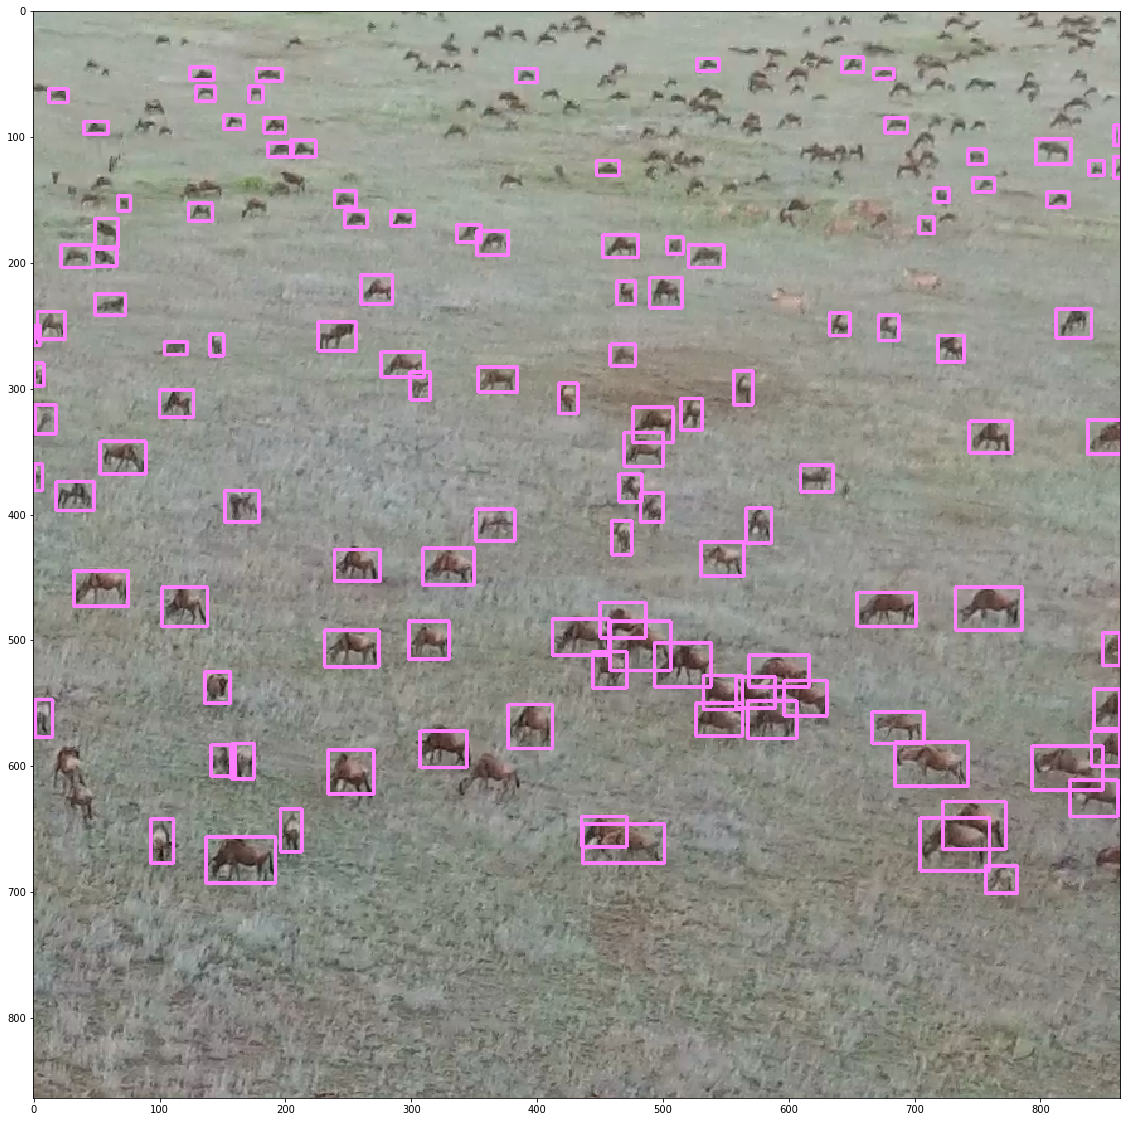

In [2]:
image_dir =  '../train_images_1/'
train_dir = '../train_images_1/'



im_size=864 #size of training imageas for yolo
##################################################
#im_size=416 #size of training imageas for yolo
yolov3 = get_yolo_model(im_size,im_size,num_class=1,trainable=False)
#yolov3.load_weights('../weights/yolo-v3-coco.h5',by_name=True)
yolov3.load_weights('../weights/balloon-yolo.h5')
#print(yolov3.summary())
image_dir = 'train_images_1/'
image_name = image_dir + 'TR_DJI_0363-123-6.png'

im = cv2.imread(image_name)

new_image = im[:,:,::-1]/255.
new_image = np.expand_dims(new_image, 0)
aa = np.tile(new_image, (2,1,1,1))

            # run the prediction
yolos = yolov3.predict(aa)

boxes = decode(yolos,0.7)#, im_size, 'predictions.png', im)
for box in boxes:
    xmin  = int((box[0]))
    xmax  = int((box[2]))
    ymin  = int((box[1]))
    ymax  = int((box[3]))
    
    
    cv2.rectangle(im, (xmin,ymin), (xmax,ymax), (255,125,255), 2)
plt.figure(figsize=(20,20))
plt.imshow(im)
#cv2.imwrite('43.JPG',image)
plt.show()

In [ ]:


anchors = np.array([[19.83730159, 18.67857143], [ 28.15488215, 15.51178451], [ 16.42857143, 26.46616541]])

nb_box=3
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def bbox_iou(box1, box2):
    
    intersect_w = _interval_overlap([box1[0], box1[2]], [box2[0], box2[2]])
    intersect_h = _interval_overlap([box1[1], box1[3]], [box2[1], box2[3]])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1[2]-box1[0], box1[3]-box1[1]
    w2, h2 = box2[2]-box2[0], box2[3]-box2[1]
    
    union = w1*h1 + w2*h2 - intersect
    #if float(intersect) / union < 0.5:
    #    if float(intersect) / union > 0.25:
    #        print(box1[0],box1[1],box1[2],box1[3])
    #        print(box2[0],box2[1],box2[2],box2[3])
    return float(intersect) / union

In [ ]:

IMAGE_H, IMAGE_W = 864,864


#IMAGE_H, IMAGE_W = 4928, 7360

model = get_yolo_model(IMAGE_W,IMAGE_H,trainable=False)
model.load_weights('../weights/yolo-v3-coco.h5', by_name=True)
#model.load_weights('../weights/balloon-yolo.h5')

In [ ]:
image_dir = 'train_images_1/'
image_name = image_dir + 'TR_DJI_0363-123-6.png'

img = cv2.imread(image_name)#1077.JPG') #1149.JPG')

img = img[0:IMAGE_H, 0:IMAGE_W,:]
#img = img[IMAGE_H:, 0:IMAGE_W,:]
#img = img[0:IMAGE_H, IMAGE_W:,:]
#img = img[IMAGE_H:, IMAGE_W:,:]
input_image = cv2.resize(img, (IMAGE_W, IMAGE_H))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)


In [ ]:
input_image.shape

In [ ]:
startall = time.time()

netout = model.predict(input_image)
end = time.time()
print(len(netout))
print('all', end - startall)


In [ ]:

obj_thresh=0.1
nms_thresh=0.1
new_boxes = np.zeros((0,5))
for output in netout:
    xpos =output[...,0]
    ypos =output[...,1]
    wpos = output[...,2]
    hpos = output[...,3]
    output[..., 5:]  = output[..., 4][..., np.newaxis] * output[..., 5:]
    
    objectness = np.max(output[...,5:],axis=-1)

    # select only objects above threshold
    indexes = objectness > obj_thresh
    print(np.sum(indexes),np.sum(indexes==False))

    new_boxes = np.vstack((new_boxes,np.column_stack((xpos[indexes]-wpos[indexes]/2, \
                             ypos[indexes]-hpos[indexes]/2, \
                             xpos[indexes]+wpos[indexes]/2, \
                             ypos[indexes]+hpos[indexes]/2, \
                             objectness[indexes]))))
        

# do nms 
sorted_indices = np.argsort(-new_boxes[:,4])
boxes=new_boxes.tolist()

for i in range(len(sorted_indices)):
    index_i = sorted_indices[i]

    if new_boxes[index_i,4] == 0: continue

    for j in range(i+1, len(sorted_indices)):
        index_j = sorted_indices[j]
        if bbox_iou(boxes[index_i][0:4], boxes[index_j][0:4]) >= nms_thresh:
            new_boxes[index_j,4] = 0

new_boxes = new_boxes[new_boxes[:,4]>0]

In [ ]:

for i in range(len(sorted_indices)):
    index_i = sorted_indices[i]

    if new_boxes[index_i,4] == 0: continue

    for j in range(i+1, len(sorted_indices)):
        index_j = sorted_indices[j]
        if bbox_iou(boxes[index_i][0:4], boxes[index_j][0:4]) >= nms_thresh:
            new_boxes[index_j,4] = 0

new_boxes = new_boxes[new_boxes[:,4]>0]

In [ ]:
objectness.shape

In [ ]:

        # decode the output of the network
        boxes += decode_netout(yolos[i][0], anchors[i], im_size, im_size)

grid_h, grid_w = netout.shape[:2]
netout = netout.reshape(grid_h,grid_w,nb_box,-1)

# convert from raw output
netout[..., :2]  = _sigmoid(netout[..., :2])
netout[..., 4:]  = _sigmoid(netout[..., 4:])
netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]

# process the coordinates
x = np.linspace(0, grid_w-1, grid_w)
y = np.linspace(0, grid_h-1, grid_h)

xv,yv = np.meshgrid(x, y)
xv = np.expand_dims(xv, -1)
yv = np.expand_dims(yv, -1)


for b in range(nb_box):
    wpos[...,b] *= anchors[b,0]
    hpos[...,b] *= anchors[b,1]




In [ ]:


img = cv2.imread(image_name)#1077.JPG') #1149.JPG')


image = img[0:IMAGE_H, 0:IMAGE_W,:]
#image = img[IMAGE_H:, 0:IMAGE_W,:]
#image = img[0:IMAGE_H, IMAGE_W:,:]
#image = img[IMAGE_H:, IMAGE_W:,:]
for box in new_boxes:
    xmin  = int((box[0]))
    xmax  = int((box[2]))
    ymin  = int((box[1]))
    ymax  = int((box[3]))
    
    
    cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,0,255), 4)
plt.figure(figsize=(20,20))
plt.imshow(image[:,:,::-1])
#cv2.imwrite('43.JPG',image)
plt.show()


In [ ]:

img = cv2.imread(image_name)#1077.JPG') #1149.JPG')


image = img[0:IMAGE_H, 0:IMAGE_W,:]

plt.figure(figsize=(20,20))
plt.imshow(image[:,:,::-1])
#cv2.imwrite('43.JPG',image)
plt.show()

In [ ]:
new_boxes[:,4]

In [ ]:
4912/32


In [ ]:
len(new_boxes)

In [ ]:
cert